In [1]:
import xarray as xr
import math
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import cf_units
import datetime

In [3]:
sea_level_dataset = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')
sea_level_dataarray = sea_level_dataset['sea_level']
#yt = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')['lat'].data
#xt = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol_rechunked.zarr')['long'].data
sea_level_dataarray

,Array,Chunk
Bytes,227.21 GB,22.72 MB
Shape,"(5844, 2700, 3600)","(5844, 27, 36)"
Count,10001 Tasks,10000 Chunks
Type,float32,numpy.ndarray


In [4]:
def location(xt, yt, time):
    interval1 = sea_level_dataarray.sel(xt_ocean= xt, yt_ocean= yt, method="nearest").isel(time = slice(0,time))
    interval11 = np.array(interval1)
    timeint1 = interval1['time']
    timearray1int = np.array(timeint1)
    timearray11 = cf_units.date2num(timearray1int,'days since 0185-01-01 12:00:00' , calendar='julian')
    seaarray_torch = torch.FloatTensor(interval11).squeeze()
    timearray_torch = torch.FloatTensor(timearray11).squeeze()
    x_new = torch.cat((timearray_torch[0:500], timearray_torch[1000:1500], timearray_torch[1600:1800] , timearray_torch[2000:2500],timearray_torch[3000:3500]))
    y_new = torch.cat((seaarray_torch[0:500], seaarray_torch[1000:1500], seaarray_torch[1600:1800], seaarray_torch[2000:2500], seaarray_torch[3000:3500]))
    return x_new, y_new

train_x, train_y = location(-150,20, 300)


# #The following boxes are for the 
# #________________________
# interval1 = sea_level_dataarray.sel(xt_ocean= -150, yt_ocean= 20, method="nearest").isel(time = slice(0,5844))

# #This interval is half of the original data set, will be the training data output, y

# timeint1 = interval1['time']

# #Interval.plot()
# timearray1int = np.array(timeint1)
# timearray11 = cf_units.date2num(timearray1int,'days since 0185-01-01 12:00:00' , calendar='julian')


# #need to convert to nparray to then become a torch tensor
# interval11 = np.array(interval1)

# seaarray_torch = torch.FloatTensor(interval11).squeeze()

# timearray_torch = torch.FloatTensor(timearray11).squeeze()

# x_new = torch.cat((timearray_torch[0:500], timearray_torch[1000:1500], timearray_torch[1600:1800] , timearray_torch[2000:2500],timearray_torch[3000:3500]))

# y_new = torch.cat((seaarray_torch[0:500], seaarray_torch[1000:1500], seaarray_torch[1600:1800], seaarray_torch[2000:2500], seaarray_torch[3000:3500]))


# #print(timearray_torch)
# #print(seaarray_torch)

# # plt.plot(timearray2, seaarray2)

In [5]:
#model
# train_x = x_new
# train_y = y_new

x_mean = train_x.mean()
x_std = train_x.std()

train_x = (train_x - x_mean)/x_std

y_mean = train_y.mean()
y_std = train_y.std()

train_y = (train_y - y_mean)/y_std

#All you need to describe a gp is a mean and covariance, simplest way is to make a class that has both of those. Then you have everything you need to compose a GP
#Torch is primarily DL, and they work with a forward function, it gives you a multivariate normal distribution with that variable
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
#     try matern kernel
#     +gpytorch.kernels.PeriodicKernel()


    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [6]:

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 40


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
#is a optimization alg for stochastic gradient descent for training dl models, is good for handling sparse gradients on noisy problems
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    # the loss is the marginal log likelihood, and then we just backprop to go back and update things
    loss = -mll(output, train_y)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()

/ext3/miniconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


In [7]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0,4000, 4000)
    test_x = (test_x - x_mean)/x_std
    #test_y = (test_y - y_mean)/y_std
    observed_pred = likelihood(model(test_x))
    post_samples = model(test_x).sample(sample_shape=torch.Size((1, )))
    


/ext3/miniconda3/lib/python3.8/site-packages/gpytorch/distributions/multivariate_normal.py:226: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


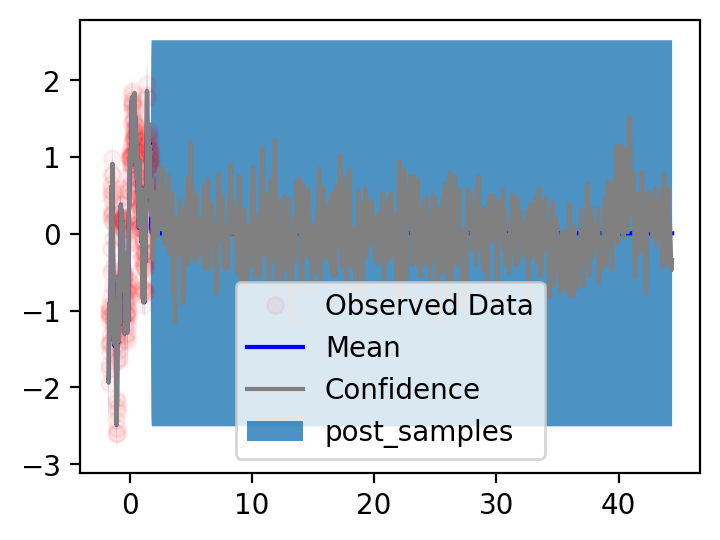

In [8]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3),dpi=200)
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as red line
    ax.plot(train_x.numpy(), train_y.numpy(), 'or', alpha= 0.05)
    # Plot predictive means as blue line
    ax.plot(test_x.numpy() ,  observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    
    ax.plot(test_x.numpy() ,  post_samples.t(), 'grey')

    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.8)
    #ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence', 'post_samples'])
    
    